In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [356]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [3]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [591]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals
f_slpf_b = sps.firwin(49, 100000/freq_hz)
f_slpf_a = [1.0]
f_slpf_offset = 24

# This is used to remove HF noise in rot detection check later
f_lpf_b = sps.firwin(49, 2000000/freq_hz)
f_lpf_a = [1.0]
f_lpf_offset = 24

# This does the *real* work of detecting syncs...

f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [592]:
infd = open('rotplane.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

lpfdata = sps.lfilter(f_lpf_b, f_lpf_a, data)[f_lpf_offset:]

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
data_despike = data.copy()
data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)

slpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data_despike)[f_slpf_offset:]
sdata = slpfdata < synctrig

sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
# Clip sfdata so there are no false low peaks
sfdata[np.where(sfdata < .05)] = .05



In [593]:

def inrange(x, mi, ma):
    return (x >= mi) and (x <= ma)

def inrange_fsc(x, mi, ma):
    xf = x / FSC
    return (xf >= mi) and (xf <= ma)


In [594]:
# This is a (seemingly) reliable indicator of a VSYNC transition - or possibly *severe* rot.
invsync = sfdata > 0.6
# Catch the edges, and add one to the results to easily determine rising/falling edges
vsync_boundary = (np.where(np.diff(invsync))[0]) + 1

fields = []

for v in range(0, len(vsync_boundary)):
    if invsync[vsync_boundary[v]]: # Rising edge found
        
        # Determine % of sync before sync start
        
        vb = vsync_boundary[v]
        # Rewind to the previous trough for more accurate measurement
        presync = vb - int(140 * FSC) + np.argmin(sfdata[vb - int(80 * FSC): vb])
        presync_sum = np.sum(sfdata[presync - int(227.5 * FSC * 4.25): presync])
#        print(v, vsync_boundary[v], presync_sum, end = ' ')

        # Find the end of VSYNC - with debounce protection (using regular end of VSYNC - ~66x FSC)
        for v2 in range(v + 1, len(vsync_boundary)):
            ve = vsync_boundary[v2]
            gap = vsync_boundary[v2] - vsync_boundary[v]

            if invsync[ve] == False and inrange_fsc(gap, 650, 670):
                postsync = ve + np.argmin(sfdata[ve:ve + int(80 * FSC)])
                postsync_sum = np.sum(sfdata[postsync: postsync + int(227.5 * FSC * 4.25)])

#                print(postsync_sum, presync_sum + postsync_sum)
                
                fields.append((postsync, presync_sum > postsync_sum))

print(fields)

[(106068, True), (583818, False), (1061805, True), (1539689, False), (2017234, True), (2494987, False), (2972986, True), (3450871, False), (3928412, True), (4406173, False), (4884176, True), (5362064, False), (5839611, True), (6317390, False), (6795372, True), (7273237, False), (7750781, True), (8228570, False), (8706567, True), (9184424, False), (9661955, True), (10139736, False), (10617752, True), (11095622, False)]


In [595]:
# Previously written color burst detection

# set up sync color heterodyne table first 
out_fsc = 8
out_linelen = 227.5 * out_fsc

bhet = np.empty(4096, dtype=np.complex)
for i in range(0, 4096):
        radian = (i / (out_fsc)) * 2 * np.pi
        bhet[i] = complex(np.cos(radian + (33.0/180.0)), -(np.sin(radian + (33.0/180.0))))
        bhet[i] = complex(np.cos(radian + (0.0/180.0)), -(np.sin(radian + (0.0/180.0))))

color_filter = sps.firwin(17, 0.1 / (freq_mhz / 2), window='hamming')

obhet_levels = None
obhet_angles = None

def burst_detect(data):
    global obhet_levels, obhet_angles
        
    level = 0
    phase = 0

    data = data.astype(np.float32)
    data -= np.mean(data)
        
    obhet = bhet[0:len(data)] * data
        
    obhet_filt = sps.lfilter(color_filter, [1.0], obhet)
        
    obhet_levels = np.fabs(np.absolute(obhet_filt))
    obhet_angles = np.angle(obhet_filt)

    level = np.amax(obhet_levels)
    phase = obhet_angles[np.argmax(obhet_levels)]
        
    return [level, phase]
    
def wrap_angle(angle, tgt):
    adjust = tgt - angle
        
    if (adjust > (np.pi)):
        adjust -= 2 * np.pi
    elif (adjust < (-np.pi)):
        adjust += 2 * np.pi

    return adjust

phasemult = 1 / (2 * np.pi) * FSC

    

1.57929 1820.53413655
1.57309 1820.53413655
1.52266 1820.58606533
3 6953.24627347 20058.5812393 5642.0 1819.47733891 1819.47733891 1.33773 1820.62118171
4 7029.14300575 19996.5026184 7463.0 1819.66227138 1819.66227138 1.12904 1820.6533282
5 7047.80671795 20104.4439778 9284.0 1819.87096286 1819.87096286 0.158141 1820.59019912
6 6925.48238662 20028.358696 11105.0 1820.841859 1820.841859 1.10454 1820.76673152
7 7075.71273954 20034.7235675 12926.0 1819.89546323 1819.89546323 1.10619 1820.82517097
8 7161.90125546 20209.1344557 14747.0 1819.89381111 1819.89381111 0.905696 1820.85834233
9 6959.27232545 20189.2953572 16567.0 1819.09430367 1819.09430367 1.83072 1820.90720321
10 7011.46022799 20034.0283433 18388.0 1819.16928005 1819.16928005 1.91721 1820.92431818
11 7059.79839697 20062.4185894 20210.0 1820.08279347 1820.08279347 0.789091 1820.93142033
12 7039.5622638 20034.8027023 22030.0 1819.21090877 1819.21090877 1.544 1820.92686979
13 6952.22699817 20073.4539032 23851.0 1819.4560045 1819.456

/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


 1819.81057143 1819.81057143 0.912517 1820.24778142
188 6705.74252328 20103.6007848 342470.0 1820.08748257 1820.08748257 0.100512 1820.28187386
189 6886.11293717 19780.9547889 344289.0 1818.8994877 1818.8994877 1.34593 1820.23422122
190 6655.60384265 20000.8393486 346109.0 1818.65406895 1818.65406895 1.75215 1820.22903417
191 6942.2931295 20199.8654439 347930.0 1819.24785459 1819.24785459 0.902514 1820.26648872
192 6751.84458113 19742.6902706 349750.0 1819.09748584 1819.09748584 1.48805 1820.29239735
193 6863.12587735 20176.916879 351571.0 1819.51194513 1819.51194513 0.166613 1820.23507283
194 6843.72655095 20045.9094386 353390.0 1818.83338715 1818.83338715 1.83532 1820.33073634
195 6905.89069451 19619.9566777 355209.0 1817.16468072 1817.16468072 -0.395802 1819.83646013
196 6785.85525644 19887.660123 357031.0 1822.39580154 1822.39580154 1.00393 1820.23792748
197 6891.25301346 19919.8153431 358851.0 1818.99606788 1818.99606788 1.11635 1820.22130202
198 7009.39274441 20047.5512822 360671

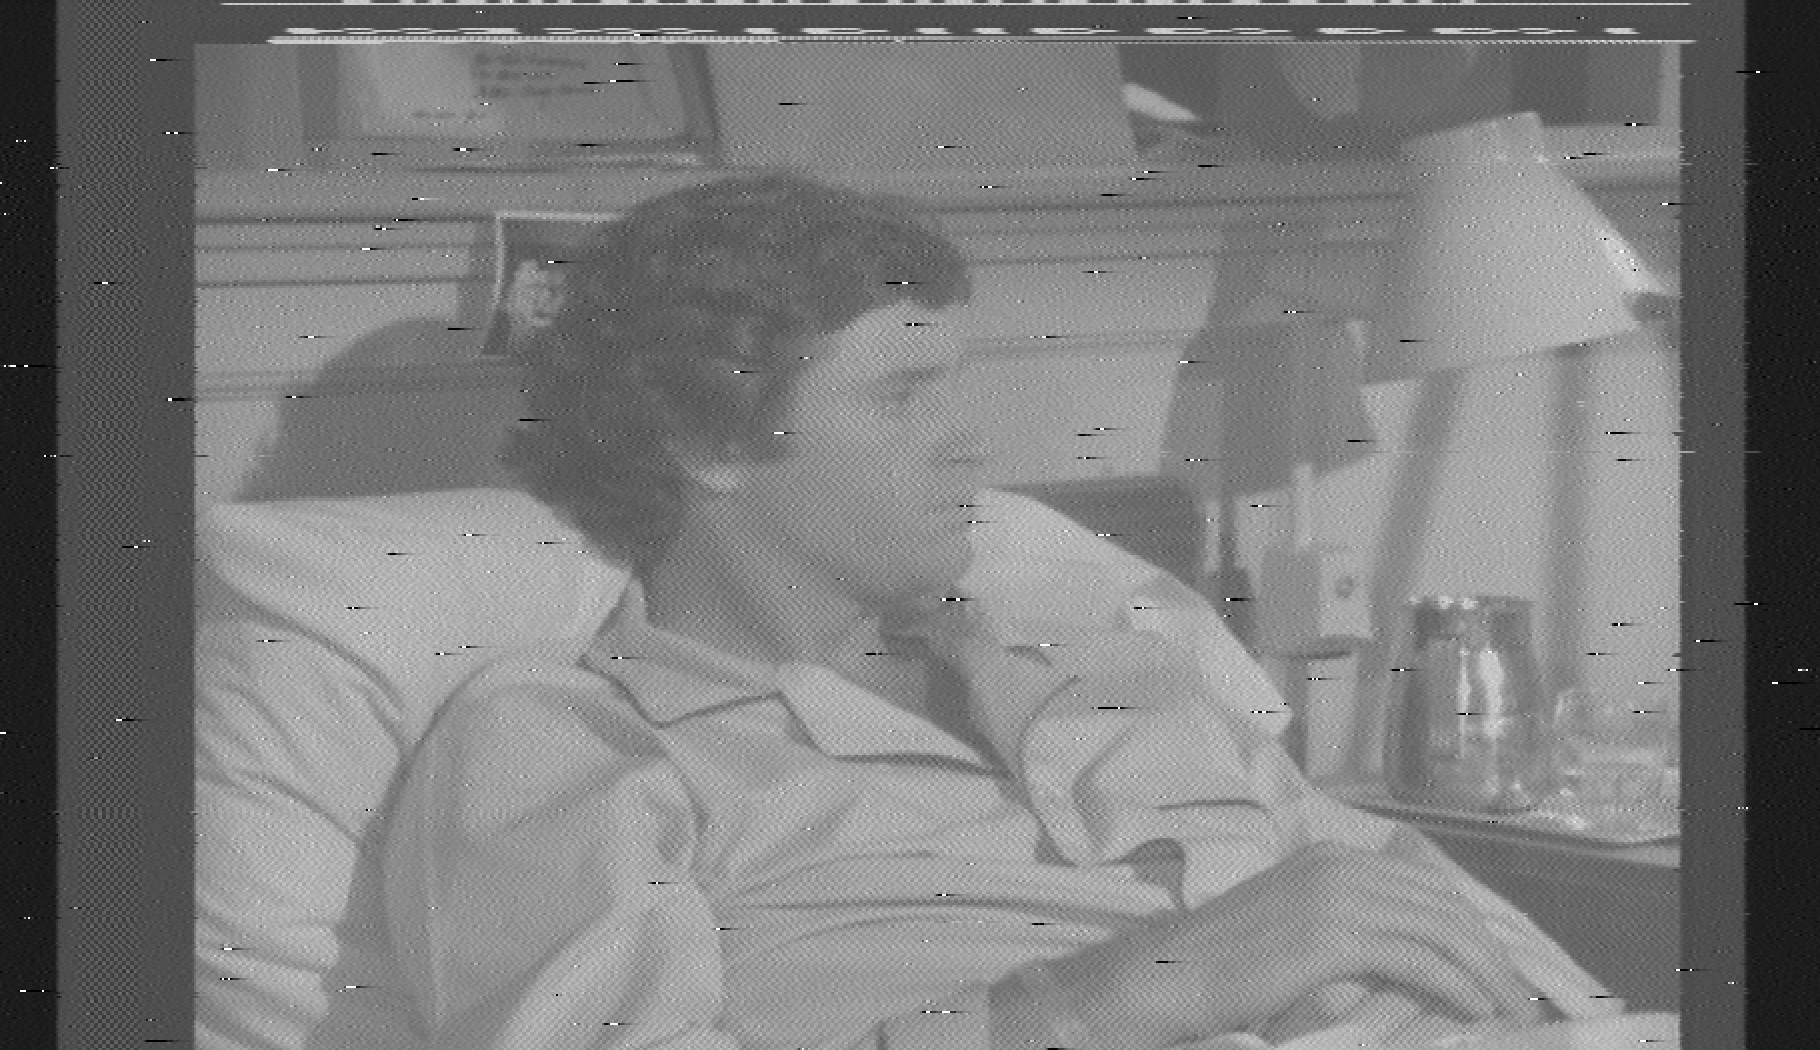

In [601]:
#for f in range(len(fields) - 1):

framebuf = np.zeros(910 * 504, dtype=np.uint16)

lineloc = np.zeros((504, 2), dtype=np.float32)

# First stage frameup - does a decent job even on rotted disks, but does not use phase/line start correction

fnum = -1
sf = 0
for f in range(sf+2, sf + 8):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
        
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    subset = sfdata[begin:begin + int(FSC * 227.5 * 255)]
    peaksr = np.logical_and((subset[1:-1] > subset[2:]), (subset[1:-1] > subset[:-2]))
    peaks = np.where(peaksr)[0].astype(np.float64)

    avg = np.full(8, ((peaks[250]-peaks[1])/249), dtype=np.float64)

    adjust = np.zeros(252, dtype=np.float32)

    lasterr = -2
    for line in range(0, 252):

        if line > 2:
            dsub = lpfdata[begin + peaks[line] - int(10 * FSC):begin + peaks[line] + int(10 * FSC)]
            ogap = peaks[line] - peaks[line - 1]
            if (np.min(dsub) < IREToRaw(-45)) or (np.min(dsub) > IREToRaw(-30)): # or (np.fabs(ogap - np.mean(avg)) > (FSC * .25)):
                lasterr = line
                gap = np.mean(avg) # peaks[line - 1] - peaks[line - 2]
                print('fix', end='')
            else:
                gap = ogap # avg + adjust[line - 1]

            peaks[line] = peaks[line - 1] + gap

            print(line, np.min(dsub), np.max(dsub), peaks[line], ogap, gap, end = ' ')
        
        lbegin = begin + peaks[line]
        burst = burst_detect(data[lbegin + 75:lbegin + 150])
        
        tgt = np.pi if np.fabs(burst[1]) > (np.pi / 2.0) else 0
        if tgt == np.pi and burst[1] < 0:
            tgt = -np.pi
        
        adjust[line] = -1.00 * phasemult * wrap_angle(tgt, burst[1])
        peaks[line] += adjust[line]
        
        if line > 1:
            avg[1:] = avg[:-1]
            avg[0] = peaks[line] - peaks[line - 1]
        
        print(adjust[line], np.mean(avg))
        

        
        # uncomment for test code
        #sline1 = scale(data, begin + peaks[line] + adjust[line], begin + peaks[line + 1] + adjust[line], 1820)
        #burst2 = burst_detect(sline1[75:150])        
        #print(line, adjust[line], burst[1], tgt, burst2[1])
            
    for line in range(0, 252):    
#        nextline = line + 1 if line < 251 else line
        lineloc[l] = [peaks[line], peaks[line + 1]]

        sline = scale(data[begin:], lineloc[l][0],lineloc[l][1], 910)
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break

drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


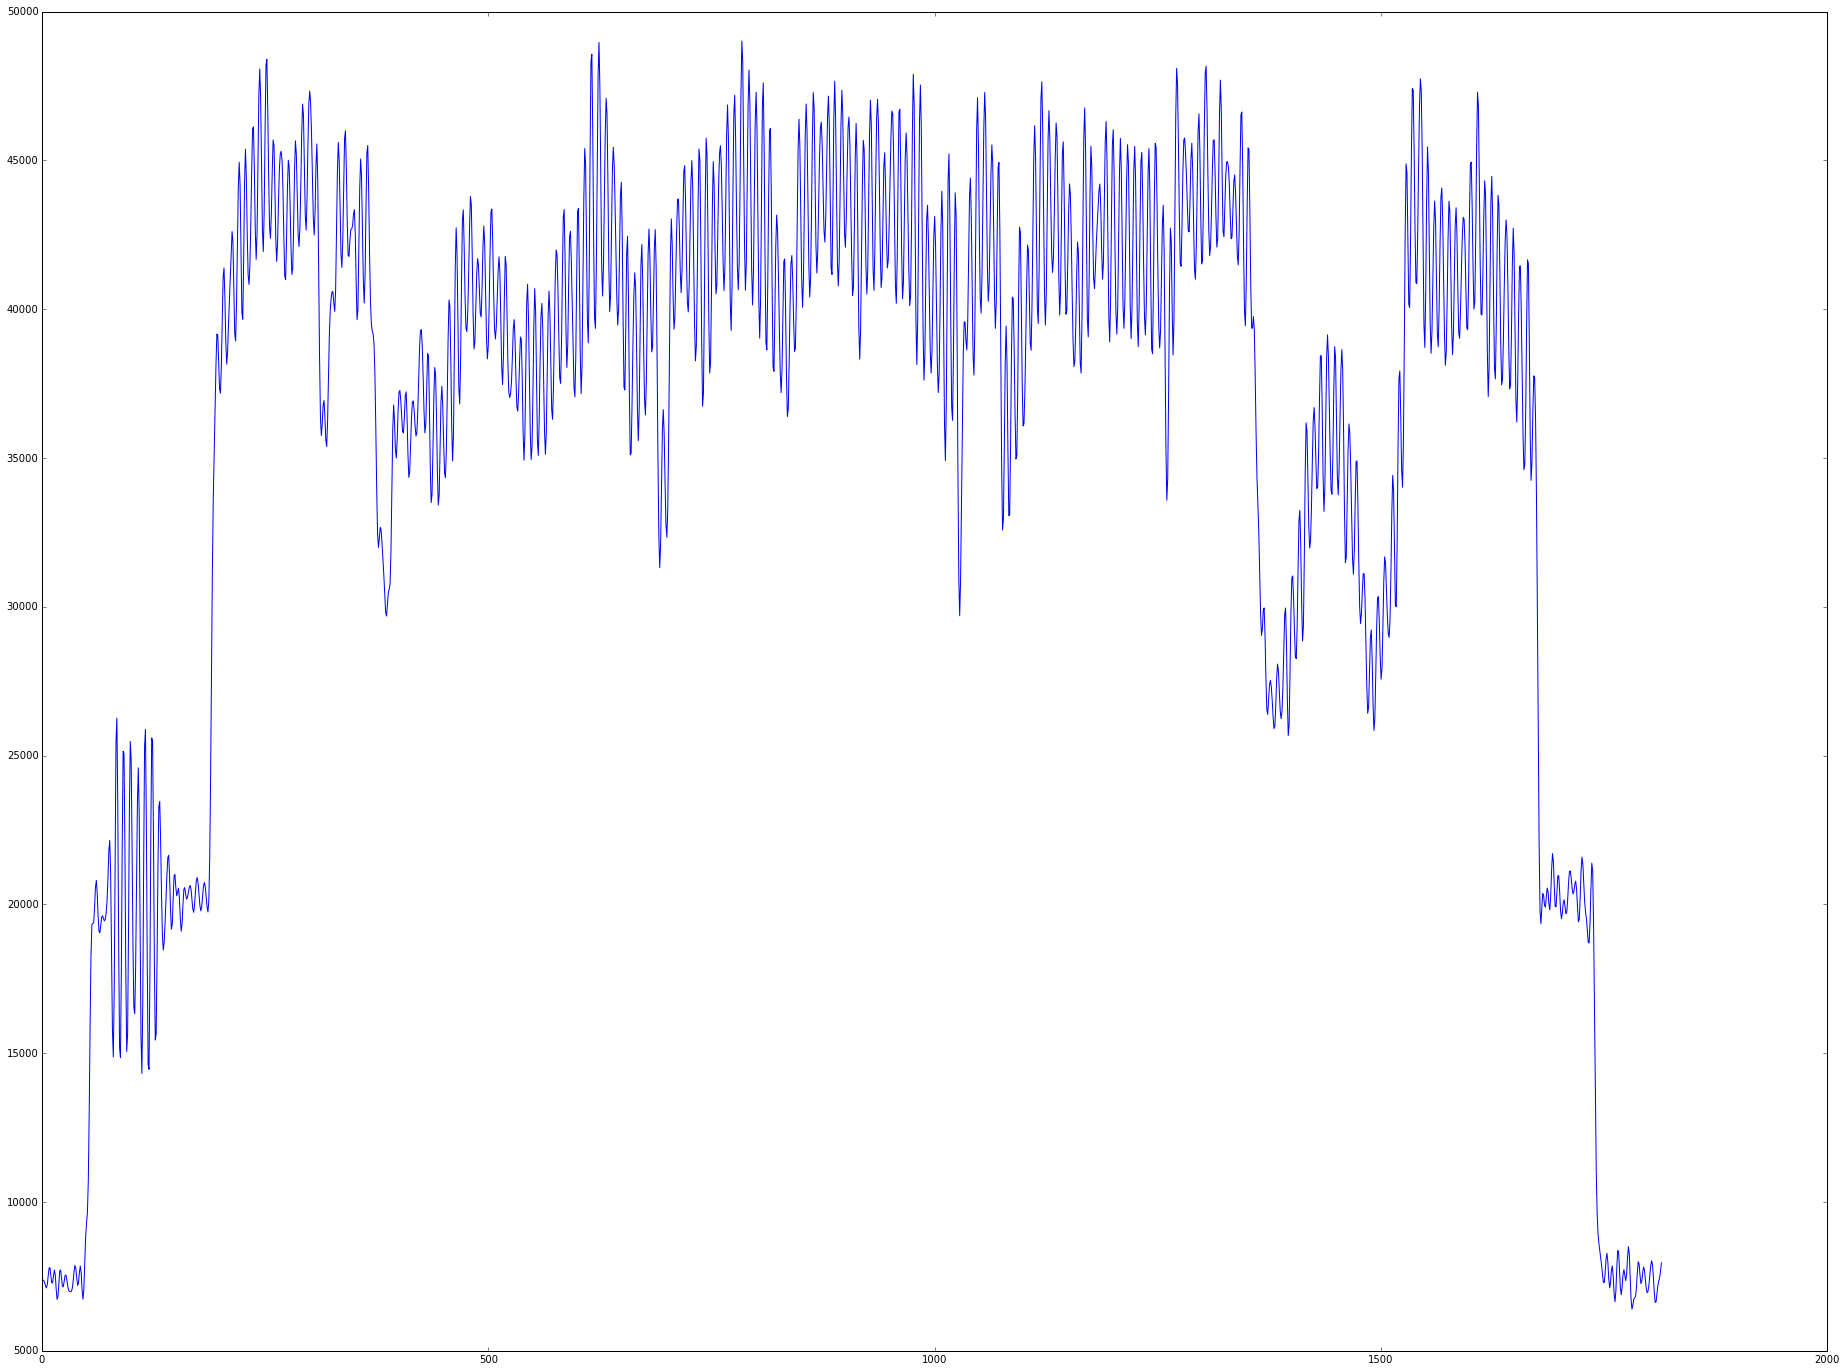

In [605]:
plt.plot(data[begin + peaks[194]:begin + peaks[195]])